In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade
from scipy.io import loadmat
import time
from silence_tensorflow import silence_tensorflow
silence_tensorflow() # to remove typcast warnings ....
tf.keras.backend.set_floatx("float64")
import pennylane as qml
import pickle

model_folder = "../../models/"
data_folder = "../../data/"
fig_folder = "../../reports/figures/"

In [2]:
with open(model_folder+'without_noise/parameter_grid/pg_results.pkl', 'rb') as handle:
    pg_dict = pickle.load(handle)
    
with open(model_folder+'without_noise/quantum_comparison/qc_results.pkl', 'rb') as handle:
    qc_dict = pickle.load(handle)
    
with open(model_folder+'without_noise/benchmark/bm_results.pkl', 'rb') as handle:
    bm_dict = pickle.load(handle)

In [3]:
### Data points used for plotting
data = loadmat(data_folder+'burgers_shock.mat')
T = data['t'].flatten()[:,None].flatten()
X = data['x'].flatten()[:,None].flatten()
exact_sol = np.real(data['usol']).T

n,m = exact_sol.shape
# # Dimensions of data
# n = 100
# m = 256
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
# del data, X, T, exact_sol, X0, T0

In [8]:
# print(pg_dict["best"]["n_qubits"])
# print(pg_dict["best"]["n_layers"])

5
5


# Parameter Grid

In [6]:
n_layers = qc_dict["quantum_replaced"]["median"]["n_layers"]
print(f"{5 + n_layers} classical layers")
print("RMSE:",qc_dict["quantum_replaced"]["median"]["RMSE"])
print("Total Parameters:",qc_dict["quantum_replaced"]["median"]["total_params"],"\n")

print("Original (9 layers)")
print("RMSE:", bm_dict["median"]["RMSE"])
print("Total Parameters:",bm_dict["median"]["total_params"],"\n")

print(f"Best hybrid")
print("RMSE:",pg_dict["best"]["RMSE"])
print("Total Parameters:",pg_dict["best"]["total_params"],"\n")

10 classical layers
RMSE: 0.08294457315172087
Total Parameters: 1581 

Original (9 layers)
RMSE: 0.08583593093257455
Total Parameters: 3441 

Best hybrid
RMSE: 0.0520717767810616
Total Parameters: 1456 



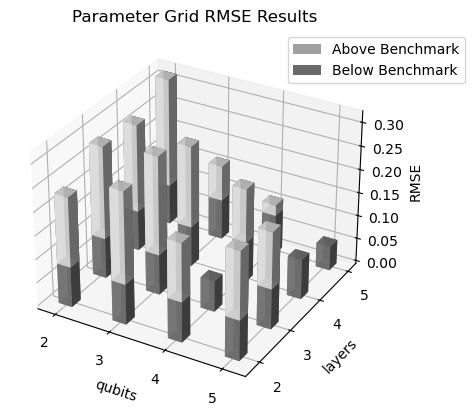

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# benchmark = qc_dict["quantum_replaced"]["median"]["RMSE"]
benchmark = bm_dict["median"]["RMSE"]


### Plot bottom of 3d bar chart
x = np.array([2]*4 + [3]*4 + [4]*4 + [5]*4)
y = np.array([2,3,4,5]*4)
height = np.array([pg_dict[i][j]['median']['RMSE'] for i in range(2,6) for j in range(2,6)])

# top = np.array([min(zs,benchmark) for zs in z])
z = np.zeros_like(x)
width = depth = 0.25
ax.bar3d(x, y, z, width, depth, height, shade=True, alpha=0.8, color='grey', label="Below Benchmark")



### Plot top of 3d bar chart
x = []
y = []
height = []
for i in range(2,6):
    for j in range(2,6):
        rmse = pg_dict[i][j]['median']['RMSE']
        if rmse >= benchmark:
            x.append(i)
            y.append(j)
            height.append(rmse-benchmark)
x = np.array(x)
y = np.array(y)
height = np.array(height)

z = np.ones_like(x)*benchmark
ax.bar3d(x, y, z, width, depth, height, shade=True, alpha=0.8, color='white', label="Above Benchmark")


### Correct tick marks
ticksx = np.arange(2.09, 6, 1)
plt.xticks(ticksx, range(2,6))

ticksy = np.arange(2.2, 6, 1)
plt.yticks(ticksy, range(2,6))


### Other settings
ax.set_title("Parameter Grid RMSE Results")
ax.set_xlabel("qubits")#, fontsize=18)
ax.set_ylabel("layers")#, fontsize=18)
ax.set_zlabel("RMSE", rotation=90)#, fontsize=18)
# Switch order of lengend
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right', bbox_to_anchor=(1.25,1))

plt.show()
fig.savefig(fig_folder+"Parameter_Grid_RMSE_Results.pdf", format="pdf", dpi = 300, bbox_inches='tight')

# Quantum Comparison

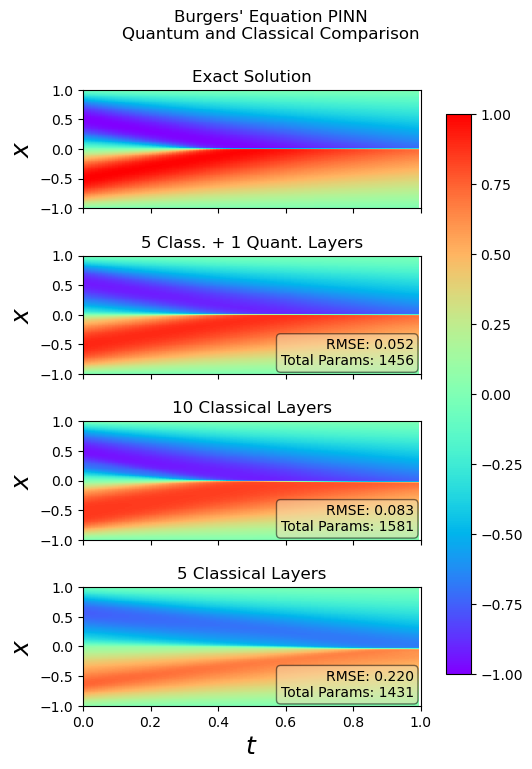

In [22]:
def axes_plot(i, S, title, rmse=None, params=None):
    pcm = axs[i].pcolormesh(T0, X0, S, cmap=cm.rainbow, vmin=-1.0, vmax=1.0)
    
    # fig.colorbar(pcm, ax=axs[i])
    xmargin = 0#0.025
    ymargin = 0#0.1
    axs[i].set_xlim(0.-xmargin, +1+xmargin)
    axs[i].set_ylim(-1-ymargin, +1+ymargin)
    axs[i].set_title(title)
    axs[i].set_ylabel("$x$", fontsize=18)
    if i == 3:
        axs[i].set_xlabel("$t$",fontsize=18)
    # if i != 0:
    #     axs[i].scatter(t_d, x_d, marker="x", c="k")
    # axs[i].tick_params(axis='both', which='major', labelsize=18)
    if i != 0:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axs[i].text(0.98, -0.9, f'RMSE: {rmse:.3f}\nTotal Params: {params}', horizontalalignment='right', verticalalignment='bottom', bbox=props)

fig, axs = plt.subplots(4,1, figsize=(5,8),sharex=True,sharey=True)

# axs[0] Exact Solution
S = exact_sol
axes_plot(0, S, "Exact Solution")

# axs[1] With Quantum
S = pg_dict["best"]["pred_sol"]
rmse = pg_dict["best"]["RMSE"]
params = pg_dict["best"]["total_params"]
axes_plot(1, S, f"5 Class. + 1 Quant. Layers", rmse, params)


# axs[2] Quantum Replaced
n_layers = qc_dict["quantum_replaced"]["median"]["n_layers"]
S = qc_dict["quantum_replaced"]["median"]["pred_sol"]
rmse = qc_dict["quantum_replaced"]["median"]["RMSE"]
params = qc_dict["quantum_replaced"]["median"]["total_params"]
axes_plot(2, S, f"{5+n_layers} Classical Layers", rmse, params)

# axs[3] Quantum Removed
S = qc_dict["quantum_removed"]["median"]["pred_sol"]
rmse = qc_dict["quantum_removed"]["median"]["RMSE"]
params = qc_dict["quantum_removed"]["median"]["total_params"]
axes_plot(3, S, f"5 Classical Layers", rmse, params)

# Other settings
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
pcm = plt.pcolormesh(T0, X0, S, cmap=cm.rainbow, vmin=-1.0, vmax=1.0)
fig.colorbar(pcm, cax=cbar_ax)
fig.suptitle("Burgers' Equation PINN\nQuantum and Classical Comparison")
plt.subplots_adjust(hspace=0.4)
plt.show()

# Save figure
fig.savefig(fig_folder+"Quantum_and_Classical_Comparison.pdf", format="pdf", dpi = 300, bbox_inches='tight')

## With Noise

In [4]:
with open(model_folder+'with_noise/parameter_grid/pg_results.pkl', 'rb') as handle:
    pgn_dict = pickle.load(handle)

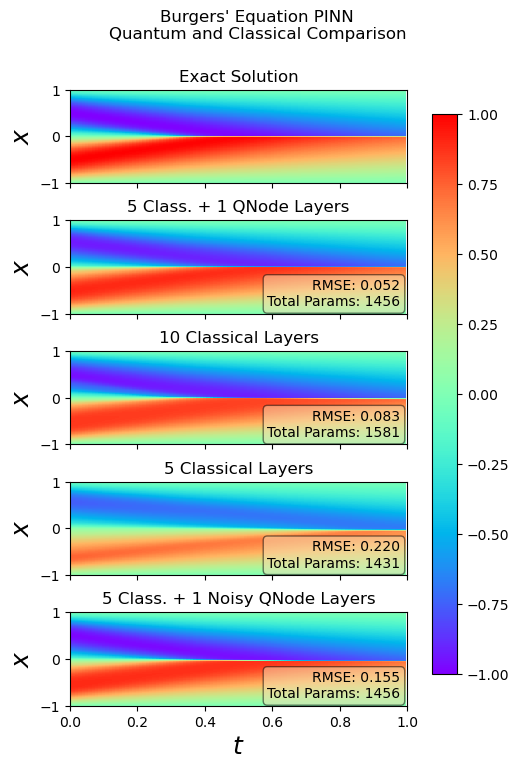

In [5]:
def axes_plot(i, S, title, rmse=None, params=None):
    pcm = axs[i].pcolormesh(T0, X0, S, cmap=cm.rainbow, vmin=-1.0, vmax=1.0)
    
    # fig.colorbar(pcm, ax=axs[i])
    xmargin = 0#0.025
    ymargin = 0#0.1
    axs[i].set_xlim(0.-xmargin, +1+xmargin)
    axs[i].set_ylim(-1-ymargin, +1+ymargin)
    axs[i].set_title(title)
    axs[i].set_ylabel("$x$", fontsize=18)
    if i == 4:
        axs[i].set_xlabel("$t$",fontsize=18)
    # if i != 0:
    #     axs[i].scatter(t_d, x_d, marker="x", c="k")
    # axs[i].tick_params(axis='both', which='major', labelsize=18)
    if i != 0:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axs[i].text(0.98, -0.9, f'RMSE: {rmse:.3f}\nTotal Params: {params}', horizontalalignment='right', verticalalignment='bottom', bbox=props)

fig, axs = plt.subplots(5,1, figsize=(5,8),sharex=True,sharey=True)

# axs[0] Exact Solution
S = exact_sol
axes_plot(0, S, "Exact Solution")

# axs[1] With Quantum
S = pg_dict["best"]["pred_sol"]
rmse = pg_dict["best"]["RMSE"]
params = pg_dict["best"]["total_params"]
axes_plot(1, S, f"5 Class. + 1 QNode Layers", rmse, params)


# axs[2] Quantum Replaced
n_layers = qc_dict["quantum_replaced"]["median"]["n_layers"]
S = qc_dict["quantum_replaced"]["median"]["pred_sol"]
rmse = qc_dict["quantum_replaced"]["median"]["RMSE"]
params = qc_dict["quantum_replaced"]["median"]["total_params"]
axes_plot(2, S, f"{5+n_layers} Classical Layers", rmse, params)

# axs[3] Quantum Removed
S = qc_dict["quantum_removed"]["median"]["pred_sol"]
rmse = qc_dict["quantum_removed"]["median"]["RMSE"]
params = qc_dict["quantum_removed"]["median"]["total_params"]
axes_plot(3, S, f"5 Classical Layers", rmse, params)

# axs[4] Quantum with Noise
S = pgn_dict[5][5]['median']['pred_sol']
rmse = pgn_dict[5][5]['median']['RMSE']
params = pgn_dict[5][5]['median']['total_params']
axes_plot(4, S, f"5 Class. + 1 Noisy QNode Layers", rmse, params)

# Other settings
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
pcm = plt.pcolormesh(T0, X0, S, cmap=cm.rainbow, vmin=-1.0, vmax=1.0)
fig.colorbar(pcm, cax=cbar_ax)
fig.suptitle("Burgers' Equation PINN\nQuantum and Classical Comparison")
plt.subplots_adjust(hspace=0.4)
plt.show()

# Save figure
fig.savefig(fig_folder+"Quantum_and_Classical_Comparison_noise.pdf", format="pdf", dpi = 300, bbox_inches='tight')